In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
tis1 =time.perf_counter()
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import random
#import tensorflow as tf#tensorflow1.x环境就用这个
import tensorflow.compat.v1 as tf#tensorflow2.x环境就用这两句
tf.get_logger().setLevel('ERROR')
tf.disable_v2_behavior()
from sklearn.preprocessing import MinMaxScaler
from scipy.io import savemat,loadmat
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score
# In[]

SSA-LSTM参数优化开始：
1 0.005881704339900828 [0.004966585656685468, 64, 16, 81]
2 0.005400125584045317 [0.001193735087666931, 95, 40, 77]
3 0.005400125584045317 [0.001193735087666931, 95, 40, 77]
4 0.005400125584045317 [0.001193735087666931, 95, 40, 77]
5 0.005400125584045317 [0.001193735087666931, 95, 40, 77]
6 0.004870852383554424 [0.0035151953227840075, 91, 1, 46]
7 0.004870852383554424 [0.0035151953227840075, 91, 1, 46]
8 0.004870852383554424 [0.0035151953227840075, 91, 1, 46]
9 0.004870852383554424 [0.0035151953227840075, 91, 1, 46]
10 0.0046736302909748855 [0.0035151953227840075, 91, 1, 46]
11 0.0046736302909748855 [0.0035151953227840075, 91, 1, 46]
12 0.0046736302909748855 [0.0035151953227840075, 91, 1, 46]
13 0.0046736302909748855 [0.0035151953227840075, 91, 1, 46]
14 0.0046736302909748855 [0.0035151953227840075, 91, 1, 46]
15 0.0046736302909748855 [0.0035151953227840075, 91, 1, 46]
16 0.0046736302909748855 [0.0035151953227840075, 91, 1, 46]
17 0.0046736302909748855 [0.00351519532278

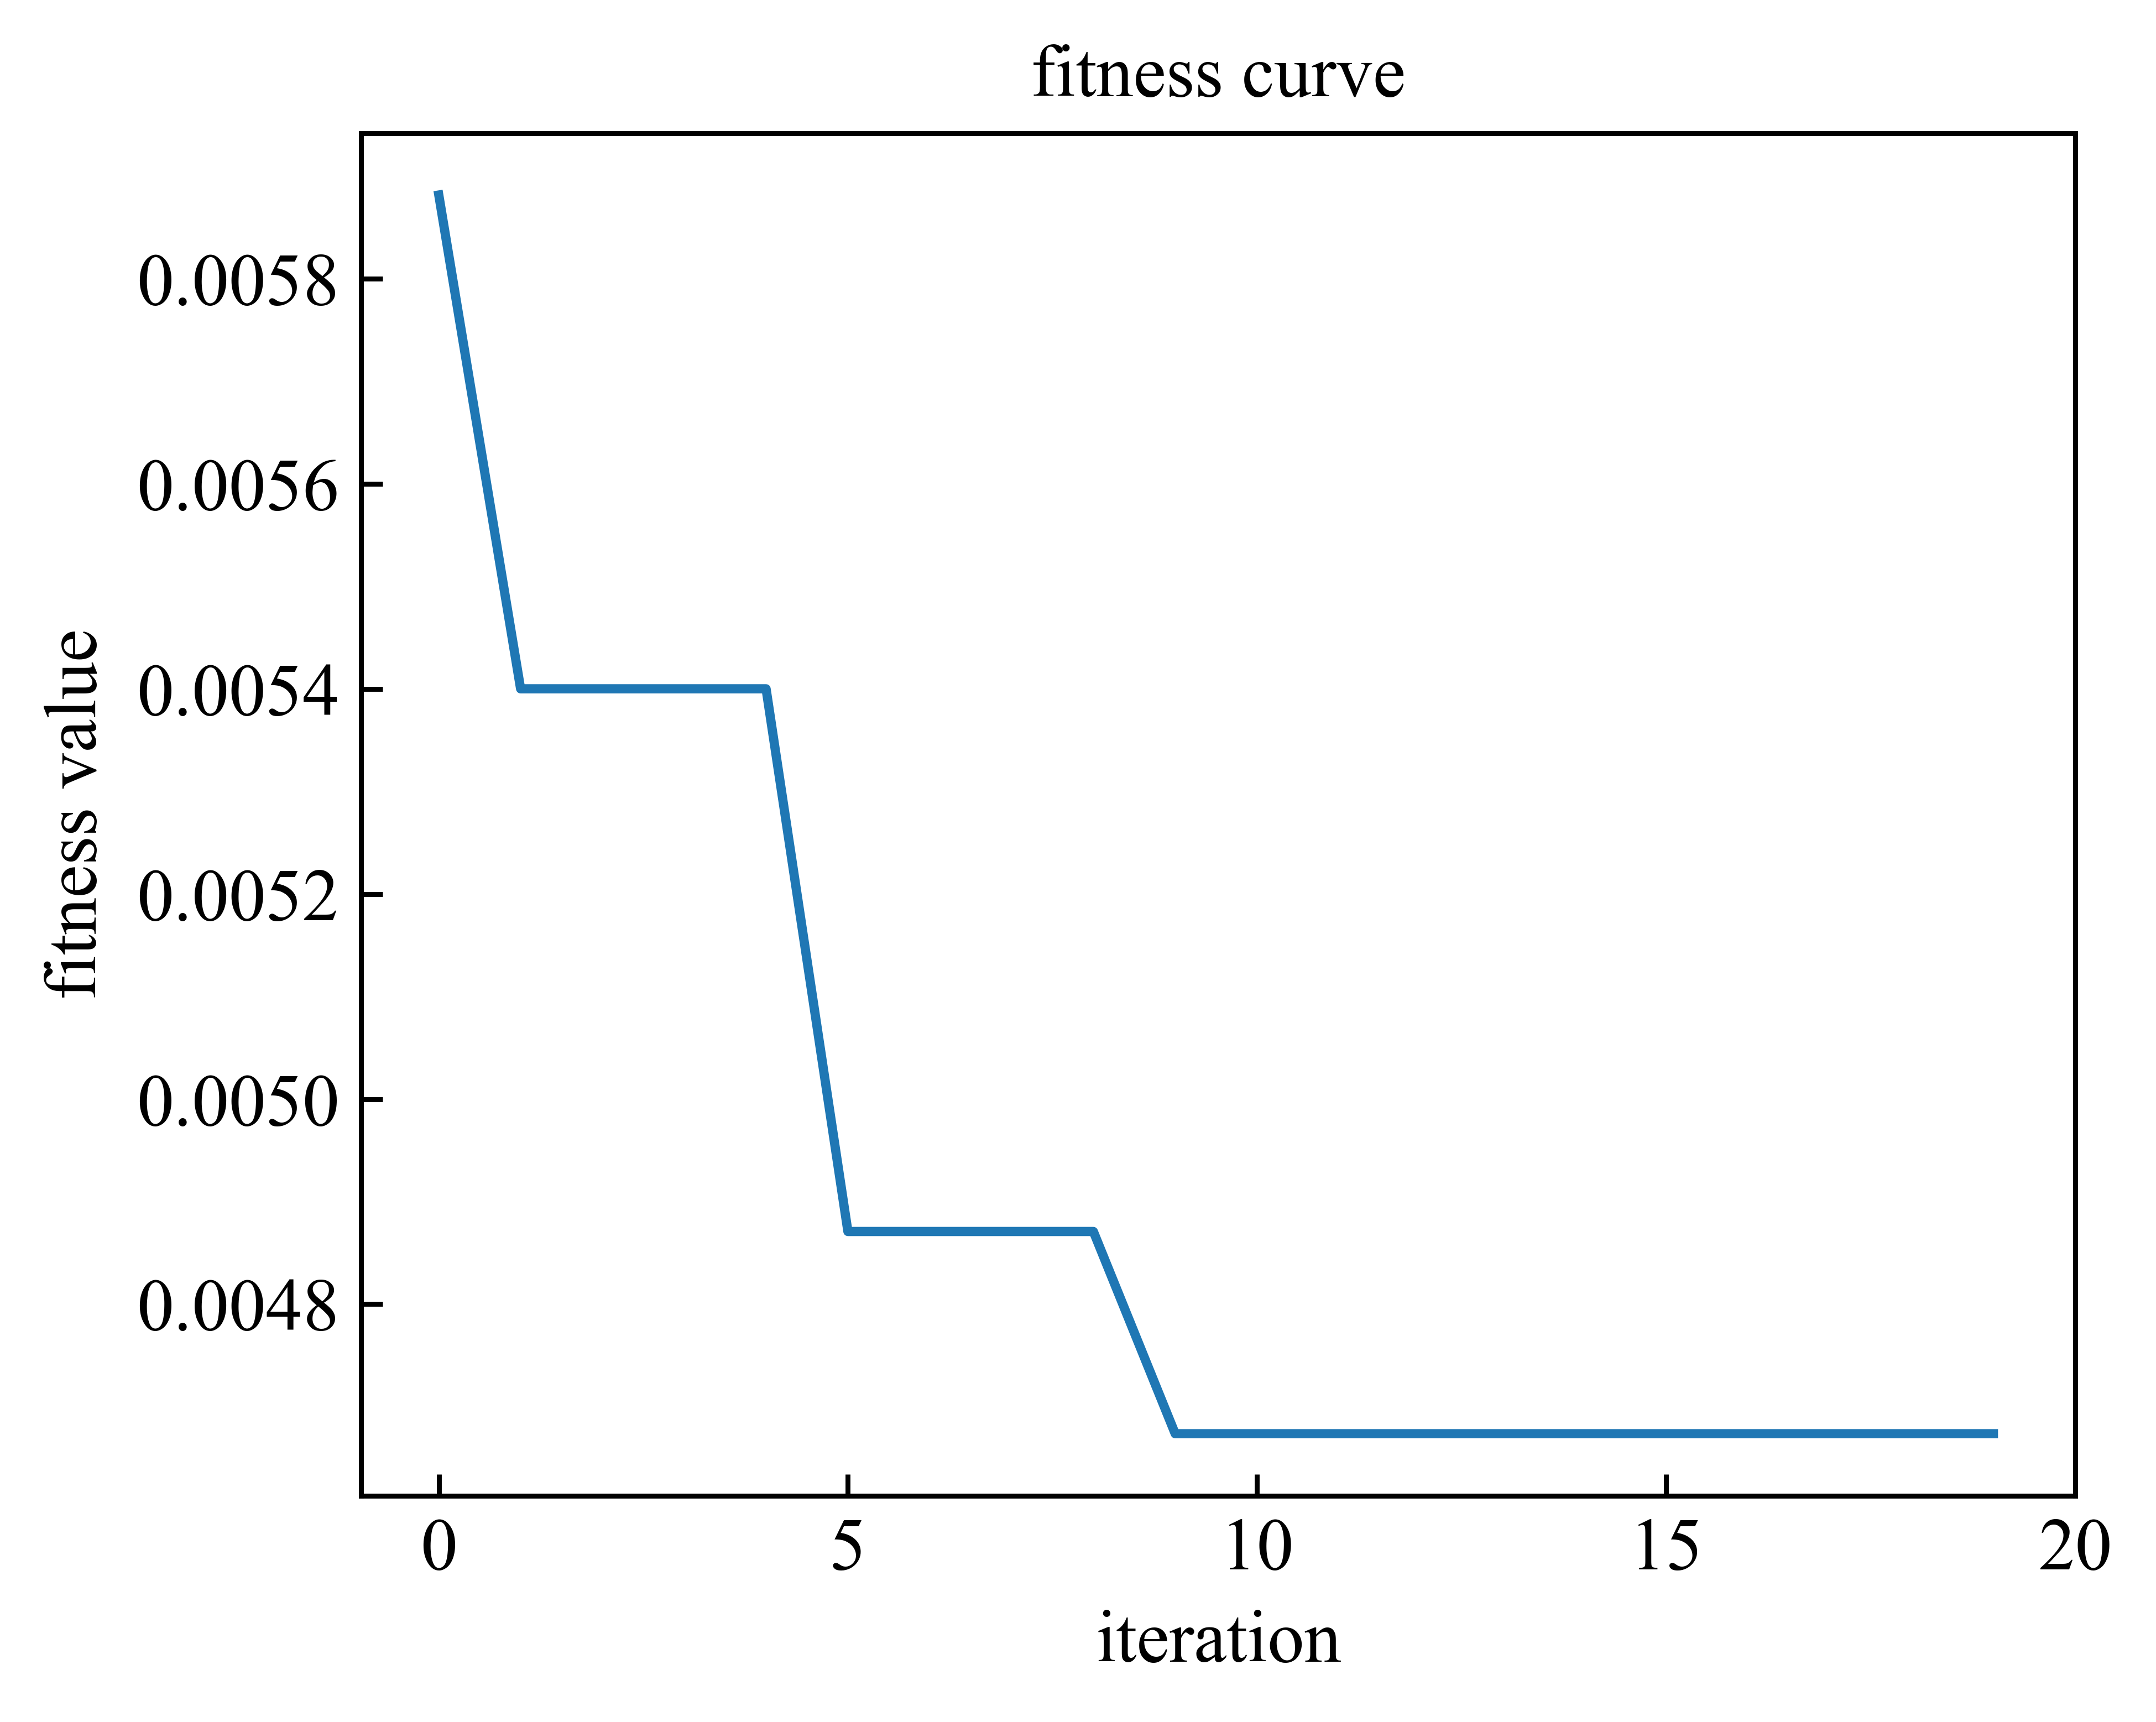

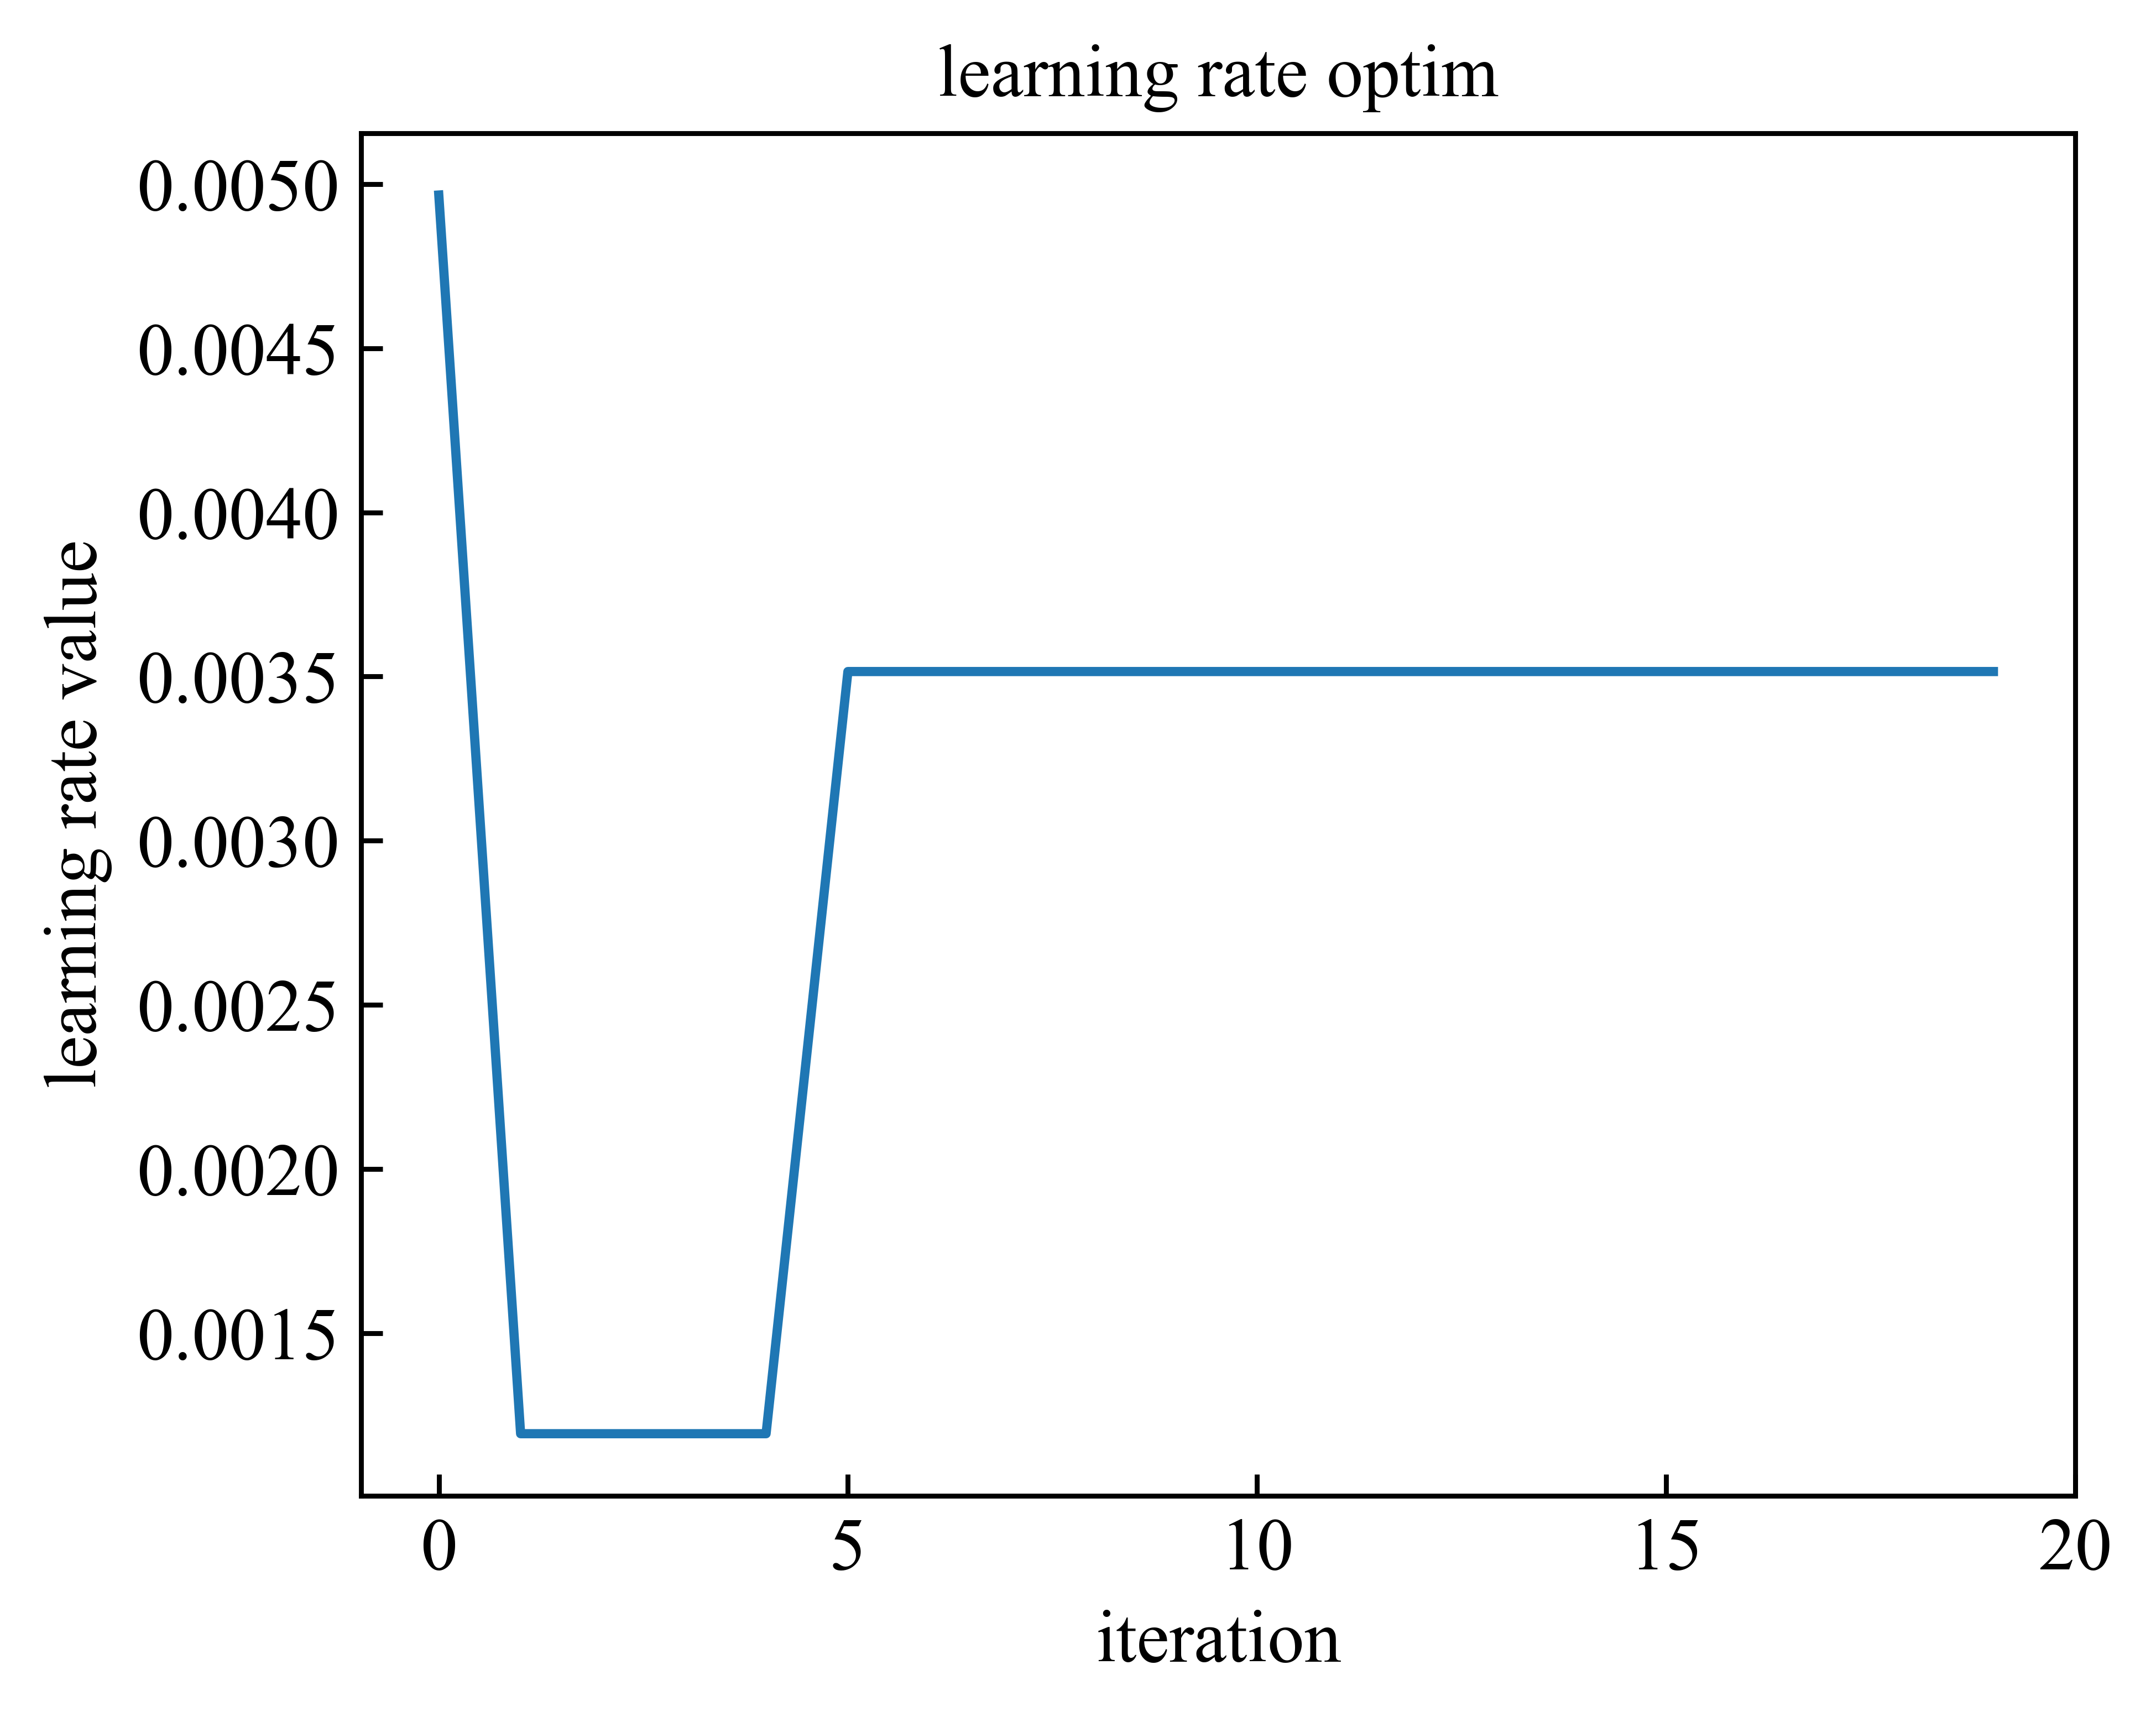

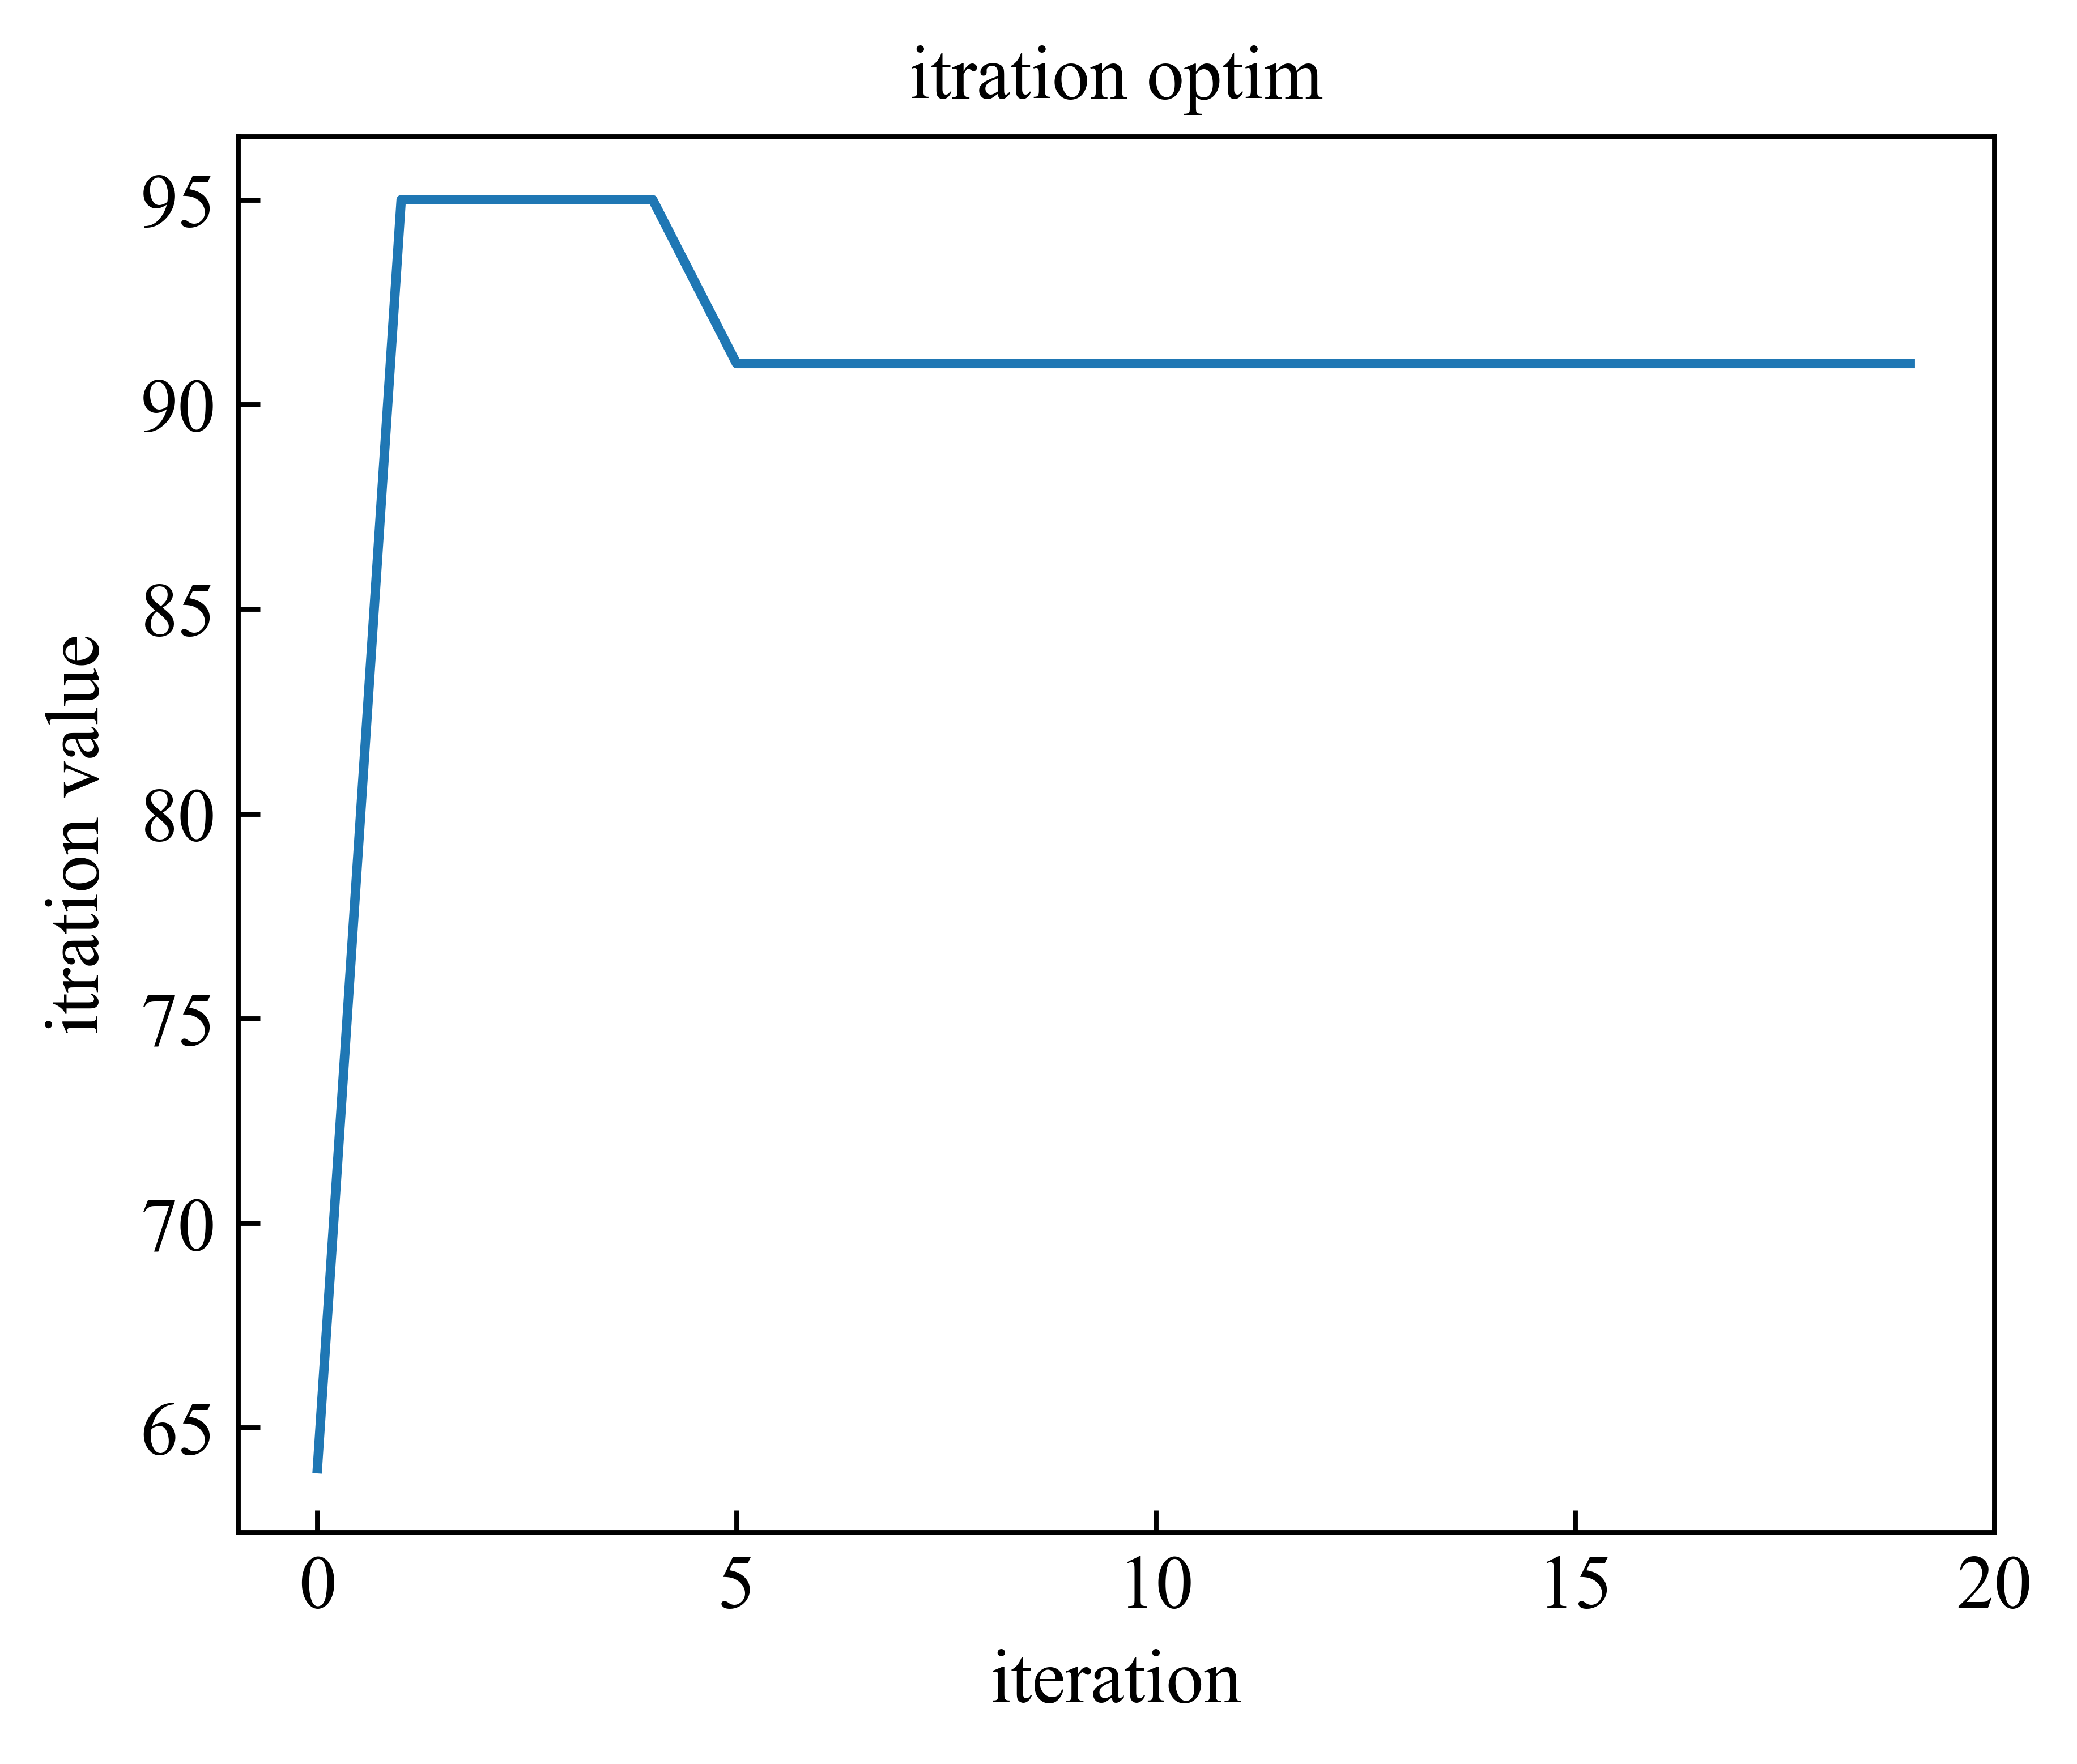

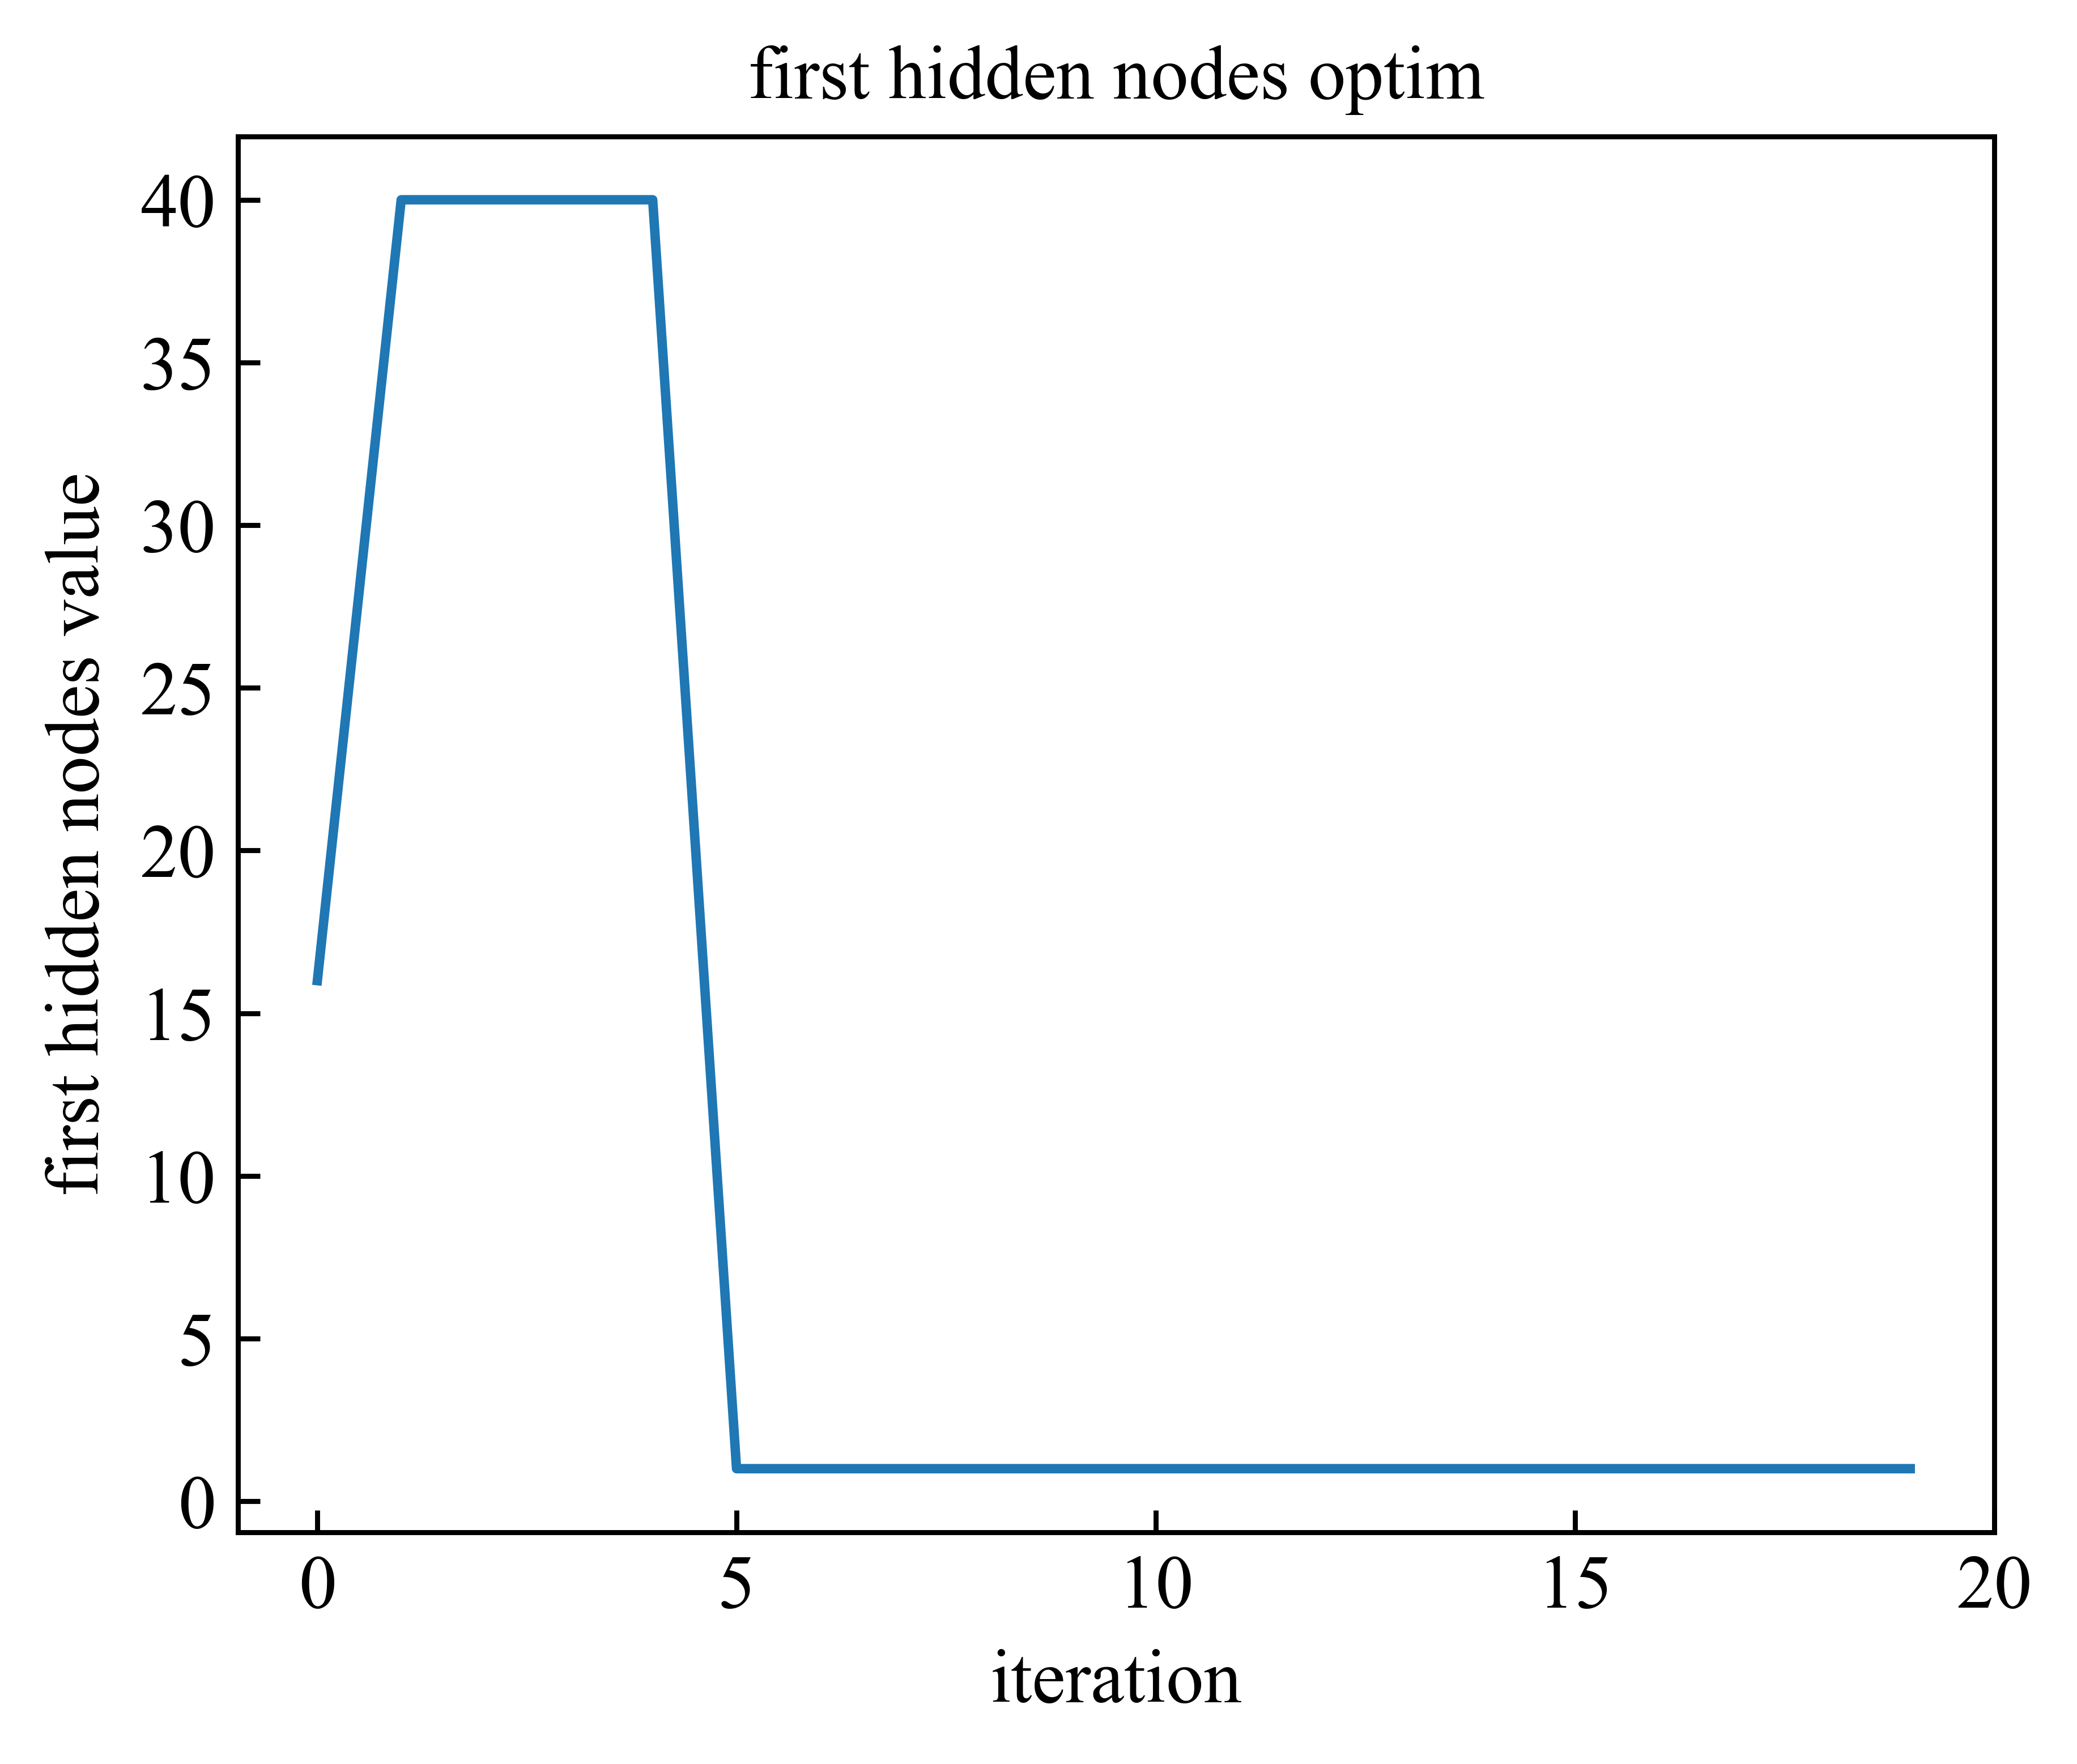

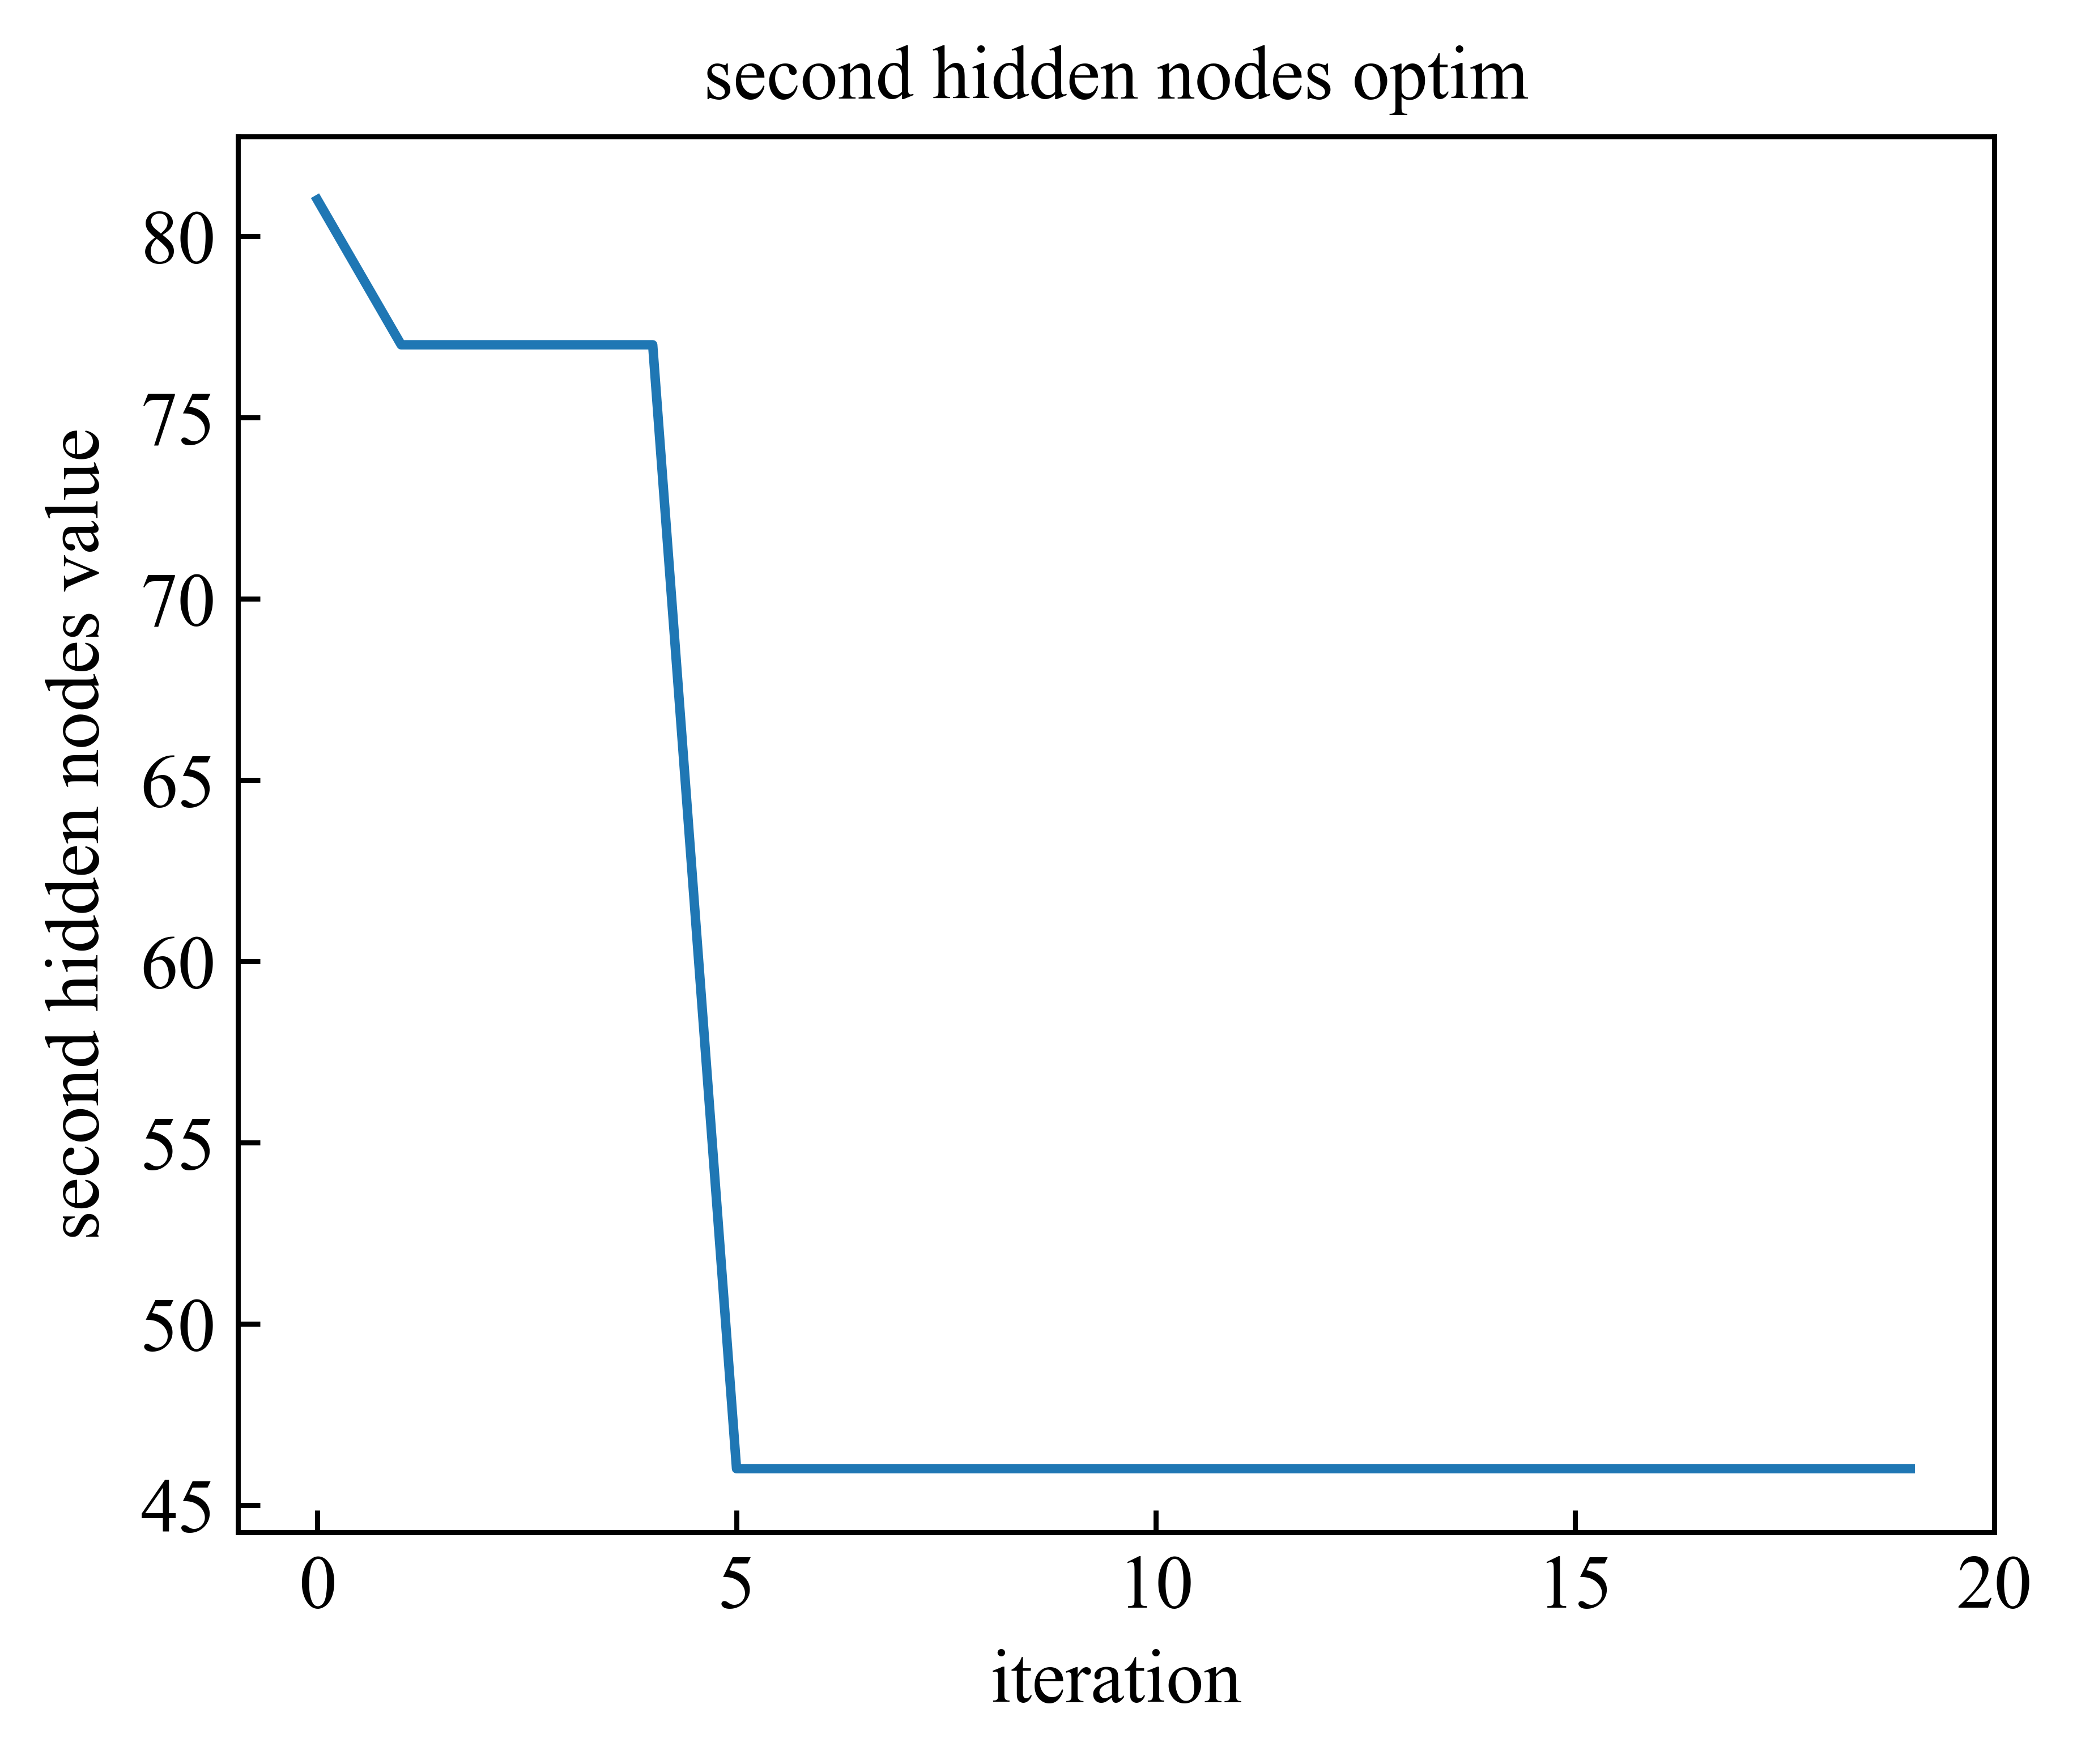

Running time: %s Seconds 1192.7888445810001


In [2]:
# -*- coding: utf-8 -*-
'''
进行适应度计算,以验证集均方差为适应度函数，目的是找到一组超参数 使得网络的误差最小
'''
def fun(pop,P,T,Pt,Tt):
    tf.reset_default_graph()
    tf.set_random_seed(0)
    alpha = pop[0]# 学习率
    num_epochs = int(pop[1])#迭代次数
    hidden_nodes0 = int(pop[2])#第一隐含层神经元
    hidden_nodes = int(pop[3])#第二隐含层神经元
    input_features = P.shape[1]
    output_class =  T.shape[1] # 34输入 24输出
    batch_size = 16# batchsize
    # placeholder
    X = tf.placeholder("float", [None, input_features])
    Y = tf.placeholder("float", [None, output_class])
    
    # 定义一个隐层的神经网络
    def RNN(x,hidden_nodes0,hidden_nodes,input_features,output_class):
        x = tf.reshape(x , [-1, 1,input_features])
        # 定义输出层权重
        weights = {'out': tf.Variable(tf.random_normal([hidden_nodes, output_class]))}
        biases = {'out': tf.Variable(tf.random_normal([output_class]))}
        lstm_cell0 = tf.nn.rnn_cell.LSTMCell(hidden_nodes0)
        lstm_cell = tf.nn.rnn_cell.LSTMCell(hidden_nodes)
        lstm_cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell0,lstm_cell])
        #初始化
        init_state = lstm_cell.zero_state(tf.shape(x)[0], dtype=tf.float32)
        outputs, _ = tf.nn.dynamic_rnn(lstm_cell, x, dtype=tf.float32, initial_state=init_state)
        
        output_sequence = tf.matmul(tf.reshape(outputs, [-1, hidden_nodes]), weights['out']) + biases['out']
        return tf.reshape(output_sequence, [-1, output_class])
    
    logits = RNN(X,hidden_nodes0,hidden_nodes,input_features,output_class)
    loss = tf.losses.mean_squared_error(predictions = logits, labels = Y)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
                    alpha,
                    global_step,
                    num_epochs, 0.99,
                    staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon = 1e-10).minimize(loss,global_step=global_step)
    init = tf.global_variables_initializer()
    
    # 训练
    with tf.Session() as sess:
        sess.run(init)
        N = P.shape[0]
        for epoch in range(num_epochs):
            total_batch = int(math.ceil(N / batch_size))
            indices = np.arange(N)
            np.random.shuffle(indices)
            avg_loss = 0
            # 迭代训练，顺便计算训练集loss
            for i in range(total_batch):
                rand_index = indices[batch_size*i:batch_size*(i+1)]
                x = P[rand_index]
                y = T[rand_index]
                _, cost = sess.run([optimizer, loss],
                                    feed_dict={X: x, Y: y})
                avg_loss += cost / total_batch
        #计算测试集的预测值

        test_pred = sess.run(logits, feed_dict={X: Pt})
        test_pred = test_pred.reshape(-1, output_class)
    
    F2=np.mean(np.square((test_pred-Tt)))
    return F2

def boundary(pop,lb,ub):
    # 防止粒子跳出范围,除学习率之外 其他的都是整数
    pop=[int(pop[i]) if i>0 else pop[i] for i in range(len(lb))]
    for i in range(len(lb)):
        if pop[i]>ub[i] or pop[i]<lb[i]:
            if i==0:
                pop[i] = (ub[i]-lb[i])*np.random.rand()+lb[i]
            else:
                pop[i] = np.random.randint(lb[i],ub[i])
    return pop
def SSA(P,T,Pt,Tt):
    M=20
    pop=10
    P_percent=0.2
    dim=4 #搜索维度,第一个是学习率[0.001 0.01]
    #第二个是迭代次数[10-100] 
    #第三和第四个是隐含层节点数[1-100]
    Lb=[0.001,10, 1,  1]
    Ub=[0.01 ,100,100,100]
    #M 迭代次数
    #pop 麻雀种群数量
    #dim 寻优维度
    #P_percent 麻雀在生产者的比例
    pNum = round( pop *  P_percent )#pNum是生产者
    x=np.zeros((pop,dim))
    # print("len",len(x[0]))
    fit=np.zeros((pop,1))
    # 种群初始化
    for i in range(pop):    
        for j in range(dim):    
            if j==0:#学习率是小数 其他的是整数
                x[i][j] = (Ub[j]-Lb[j])*np.random.rand()+Lb[j]
            else:
                x[i][j] = np.random.randint(Lb[j],Ub[j])
        
        fit[ i ]  = fun( x[ i, : ],P,T,Pt,Tt )
    pFit = fit.copy()
    pX = x.copy()
    fMin=np.min( fit )
    bestI=np.argmin( fit )
    bestX = x[bestI, : ].copy()
    Convergence_curve=np.zeros((M,))
    result=np.zeros((M,dim))

    for t in range(M):
        sortIndex = np.argsort( pFit.reshape(-1,) ).reshape(-1,)
        fmax=np.max( pFit )
        B=np.argmax( pFit )
        worse= x[B,:].copy()
        r2=np.random.rand()
        ## 这一部分为发现者（探索者）的位置更新
        if r2<0.8:#%预警值较小，说明没有捕食者出现
            for i in range(pNum):#r2小于0.8时发现者改变位置
                r1=np.random.rand()
                x[sortIndex[i],:]=pX[sortIndex[i],:]*np.exp(-i/(r1*M))
                x[sortIndex[i],:]=boundary(x[sortIndex[i],:],Lb,Ub)
                temp=fun( x[ sortIndex[ i ], : ],P,T,Pt,Tt )
                fit[ sortIndex[ i ] ] = temp# 计算新的适应度值
        else:#预警值较大，说明有捕食者出现威胁到了种群的安全，需要去其它地方觅食
            for i in range(pNum):#r2大于0.8时发现者改变位置
                r1=np.random.rand()
                x[sortIndex[i],:]=pX[sortIndex[i],:] + np.random.normal()*np.ones((1,dim))
                x[sortIndex[i],:]=boundary(x[sortIndex[i],:],Lb,Ub)
                fit[ sortIndex[ i ] ] = fun( x[ sortIndex[ i ], : ],P,T,Pt,Tt )# 计算新的适应度值
        bestII=np.argmin( fit )
        bestXX = x[ bestII, : ].copy()
        
        ##这一部分为加入者（追随者）的位置更新
        for i in range(pNum + 1,pop):#剩下的个体变化
            A=np.floor(np.random.rand(1,dim)*2)*2-1
            if i > pop/2: #这个代表这部分麻雀处于十分饥饿的状态（因为它们的能量很低，也是是适应度值很差），需要到其它地方觅食
                x[ sortIndex[i ], : ]=np.random.normal()*np.exp((worse-pX[sortIndex[ i ], : ])/(i**2))
            else:#这一部分追随者是围绕最好的发现者周围进行觅食，其间也有可能发生食物的争夺，使其自己变成生产者
                
                x[ sortIndex[ i ], : ]=bestXX+np.abs( pX[ sortIndex[ i ], : ]-bestXX).dot(A.T*(A*A.T)**(-1))*np.ones((1,dim))
            x[sortIndex[ i ], : ] = boundary( x[ sortIndex[ i ], : ],Lb,Ub)#判断边界是否超出
            fit[ sortIndex[ i ] ] = fun( x[ sortIndex[ i ], : ],P,T,Pt,Tt )#计算适应度值        
        
        #这一部分为意识到危险（注意这里只是意识到了危险，不代表出现了真正的捕食者）的麻雀的位置更新
        c=random.sample(range(sortIndex.shape[0]),sortIndex.shape[0])#这个的作用是在种群中随机产生其位置（也就是这部分的麻雀位置一开始是随机的，意识到危险了要进行位置移动，
        b=sortIndex[np.array(c)[0:round(pop*0.2)]].reshape(-1,)
        for j in range(b.shape[0]):
            if pFit[sortIndex[b[j]]]> fMin:#处于种群外围的麻雀的位置改变
                x[ sortIndex[ b[j] ], : ]=bestX+np.random.normal(1,dim)*(np.abs( pX[ sortIndex[ b[j] ], : ]  -bestX))

            else: #处于种群中心的麻雀的位置改变
                x[ sortIndex[ b[j] ], : ] =pX[ sortIndex[ b[j] ], : ] + (2*np.random.rand()-1)*(np.abs(pX[ sortIndex[ b[j] ], : ]-worse)) / (pFit[sortIndex[b[j]]]-fmax+1e-50)
            x[ sortIndex[b[j] ], : ] = boundary( x[ sortIndex[b[j]], : ],Lb,Ub)
            fit[ sortIndex[b[j] ] ] = fun( x[ sortIndex[b[j] ], : ],P,T,Pt,Tt )#计算适应度值 
        
        # 这部分是最终的最优解更新
        for i in range(pop):
            if  fit[ i ] < pFit[ i ] :
                pFit[ i ] = fit[ i ].copy()
                pX[ i, : ] = x[ i, : ].copy()
        
            if  pFit[i ] < fMin:
                fMin= pFit[ i ,0].copy()
                bestX = pX[ i, :].copy()
        result[t,:]=bestX
        print(t+1,fMin,[int(bestX[i]) if i>0 else bestX[i] for i in range(len(Lb))])    

        Convergence_curve[t]=fMin
    return bestX,Convergence_curve,result

# In[] 加载数据
xlsfile=pd.read_excel('数据集/002168li.xls').iloc[0:,1:]# 前两列的日期不作为特征之一
print("SSA-LSTM参数优化开始：")
# print(xlsfile)

data=np.array(xlsfile)

from model import split_data
time_steps=30
in_,out_=split_data(data,time_steps)
n=range(in_.shape[0])
m=-338#最后两天测试
train_data = in_[n[0:m],]
test_data = in_[n[m:],]
train_label = out_[n[0:m],]
test_label = out_[n[m:],]
# 归一化
ss_X=MinMaxScaler(feature_range=(0,1)).fit(train_data)
ss_y=MinMaxScaler(feature_range=(0,1)).fit(train_label)
train_data = ss_X.transform(train_data)
train_label = ss_y.transform(train_label)
ss_X=MinMaxScaler(feature_range=(0,1)).fit(test_data)
ss_y=MinMaxScaler(feature_range=(0,1)).fit(test_label)
test_data = ss_X.transform(test_data)
test_label = ss_y.transform(test_label)

best,trace,result=SSA(train_data,train_label,test_data,test_label)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
savemat('结果/002168lissa_para.mat',{'trace':trace,'best':best,'result':result})
# In[]
trace=loadmat('结果/002168lissa_para.mat')['trace'].reshape(-1,)
result=loadmat('结果/002168lissa_para.mat')['result']
plt.figure(figsize=(5, 4), dpi=800)
plt.plot(trace)
plt.title('fitness curve',fontproperties = 'Times New Roman', fontsize=12)
plt.xlabel('iteration',fontproperties = 'Times New Roman', fontsize=12)
plt.ylabel('fitness value',fontproperties = 'Times New Roman', fontsize=12)
my_x_ticks = np.arange(0, 21, 5)
plt.xticks(my_x_ticks)
plt.xticks(fontproperties = 'Times New Roman', fontsize=12)
plt.yticks(fontproperties = 'Times New Roman', fontsize=12)
print("fitness curve",trace)
plt.savefig("ssa_lstm图片保存/002168lifitness curve.png")

plt.figure(figsize=(5, 4), dpi=800)
plt.plot(result[:,0])
plt.title('learning rate optim',fontproperties = 'Times New Roman', fontsize=12)
plt.xlabel('iteration',fontproperties = 'Times New Roman', fontsize=12)
plt.ylabel('learning rate value',fontproperties = 'Times New Roman', fontsize=12)
my_x_ticks = np.arange(0, 21, 5)
plt.xticks(my_x_ticks)
plt.xticks(fontproperties = 'Times New Roman', fontsize=12)
plt.yticks(fontproperties = 'Times New Roman', fontsize=12)
print("learning rate optim",result[:,0])
plt.savefig("ssa_lstm图片保存/002168lilearning rate optim.png")


plt.figure(figsize=(5, 4), dpi=800)
plt.plot(result[:,1])
plt.title('itration optim',fontproperties = 'Times New Roman', fontsize=12)
plt.xlabel('iteration',fontproperties = 'Times New Roman', fontsize=12)
plt.ylabel('itration value',fontproperties = 'Times New Roman', fontsize=12)
my_x_ticks = np.arange(0, 21, 5)
plt.xticks(my_x_ticks)
plt.xticks(fontproperties = 'Times New Roman', fontsize=12)
plt.yticks(fontproperties = 'Times New Roman', fontsize=12)
print("itration optim",result[:,1])
plt.savefig("ssa_lstm图片保存/002168liitration optim.png")


plt.figure(figsize=(5, 4), dpi=800)
plt.plot(result[:,2])
plt.title('first hidden nodes optim',fontproperties = 'Times New Roman', fontsize=12)
plt.xlabel('iteration',fontproperties = 'Times New Roman', fontsize=12)
plt.ylabel('first hidden nodes value',fontproperties = 'Times New Roman', fontsize=12)
my_x_ticks = np.arange(0, 21, 5)
plt.xticks(my_x_ticks)
plt.xticks(fontproperties = 'Times New Roman', fontsize=12)
plt.yticks(fontproperties = 'Times New Roman', fontsize=12)
print("first hidden nodes optim",result[:,2])
plt.savefig("ssa_lstm图片保存/002168lifirst hidden nodes optim.png")


plt.figure(figsize=(5, 4), dpi=800)
plt.plot(result[:,3])
plt.title('second hidden nodes optim',fontproperties = 'Times New Roman', fontsize=12)
plt.xlabel('iteration',fontproperties = 'Times New Roman', fontsize=12)
plt.ylabel('second hidden nodes value',fontproperties = 'Times New Roman', fontsize=12)
my_x_ticks = np.arange(0, 21, 5)
plt.xticks(my_x_ticks)
plt.xticks(fontproperties = 'Times New Roman', fontsize=12)
plt.yticks(fontproperties = 'Times New Roman', fontsize=12)
print("second hidden nodes optim",result[:,3])
plt.savefig("ssa_lstm图片保存/002168lisecond hidden nodes optim.png")
plt.show()

tis2 =time.perf_counter()
print('Running time: %s Seconds',tis2-tis1)

epoch: 0  ,train loss  0.046676854292551674  ,valid loss:  0.03781481
epoch: 1  ,train loss  0.022046081023290753  ,valid loss:  0.03234781
epoch: 2  ,train loss  0.01372362207621336  ,valid loss:  0.02149838
epoch: 3  ,train loss  0.007740372073991845  ,valid loss:  0.014535539
epoch: 4  ,train loss  0.0049526351067470395  ,valid loss:  0.013440176
epoch: 5  ,train loss  0.003923545484819139  ,valid loss:  0.011978226
epoch: 6  ,train loss  0.003070532785689769  ,valid loss:  0.011777326
epoch: 7  ,train loss  0.003209156677864182  ,valid loss:  0.011294225
epoch: 8  ,train loss  0.002599615429062396  ,valid loss:  0.0111054825
epoch: 9  ,train loss  0.002582410340740656  ,valid loss:  0.010534017
epoch: 10  ,train loss  0.002269795705312087  ,valid loss:  0.010575946
epoch: 11  ,train loss  0.002102953803841956  ,valid loss:  0.009314036
epoch: 12  ,train loss  0.0019726875907508656  ,valid loss:  0.009096247
epoch: 13  ,train loss  0.0018174380529671907  ,valid loss:  0.009222929
ep

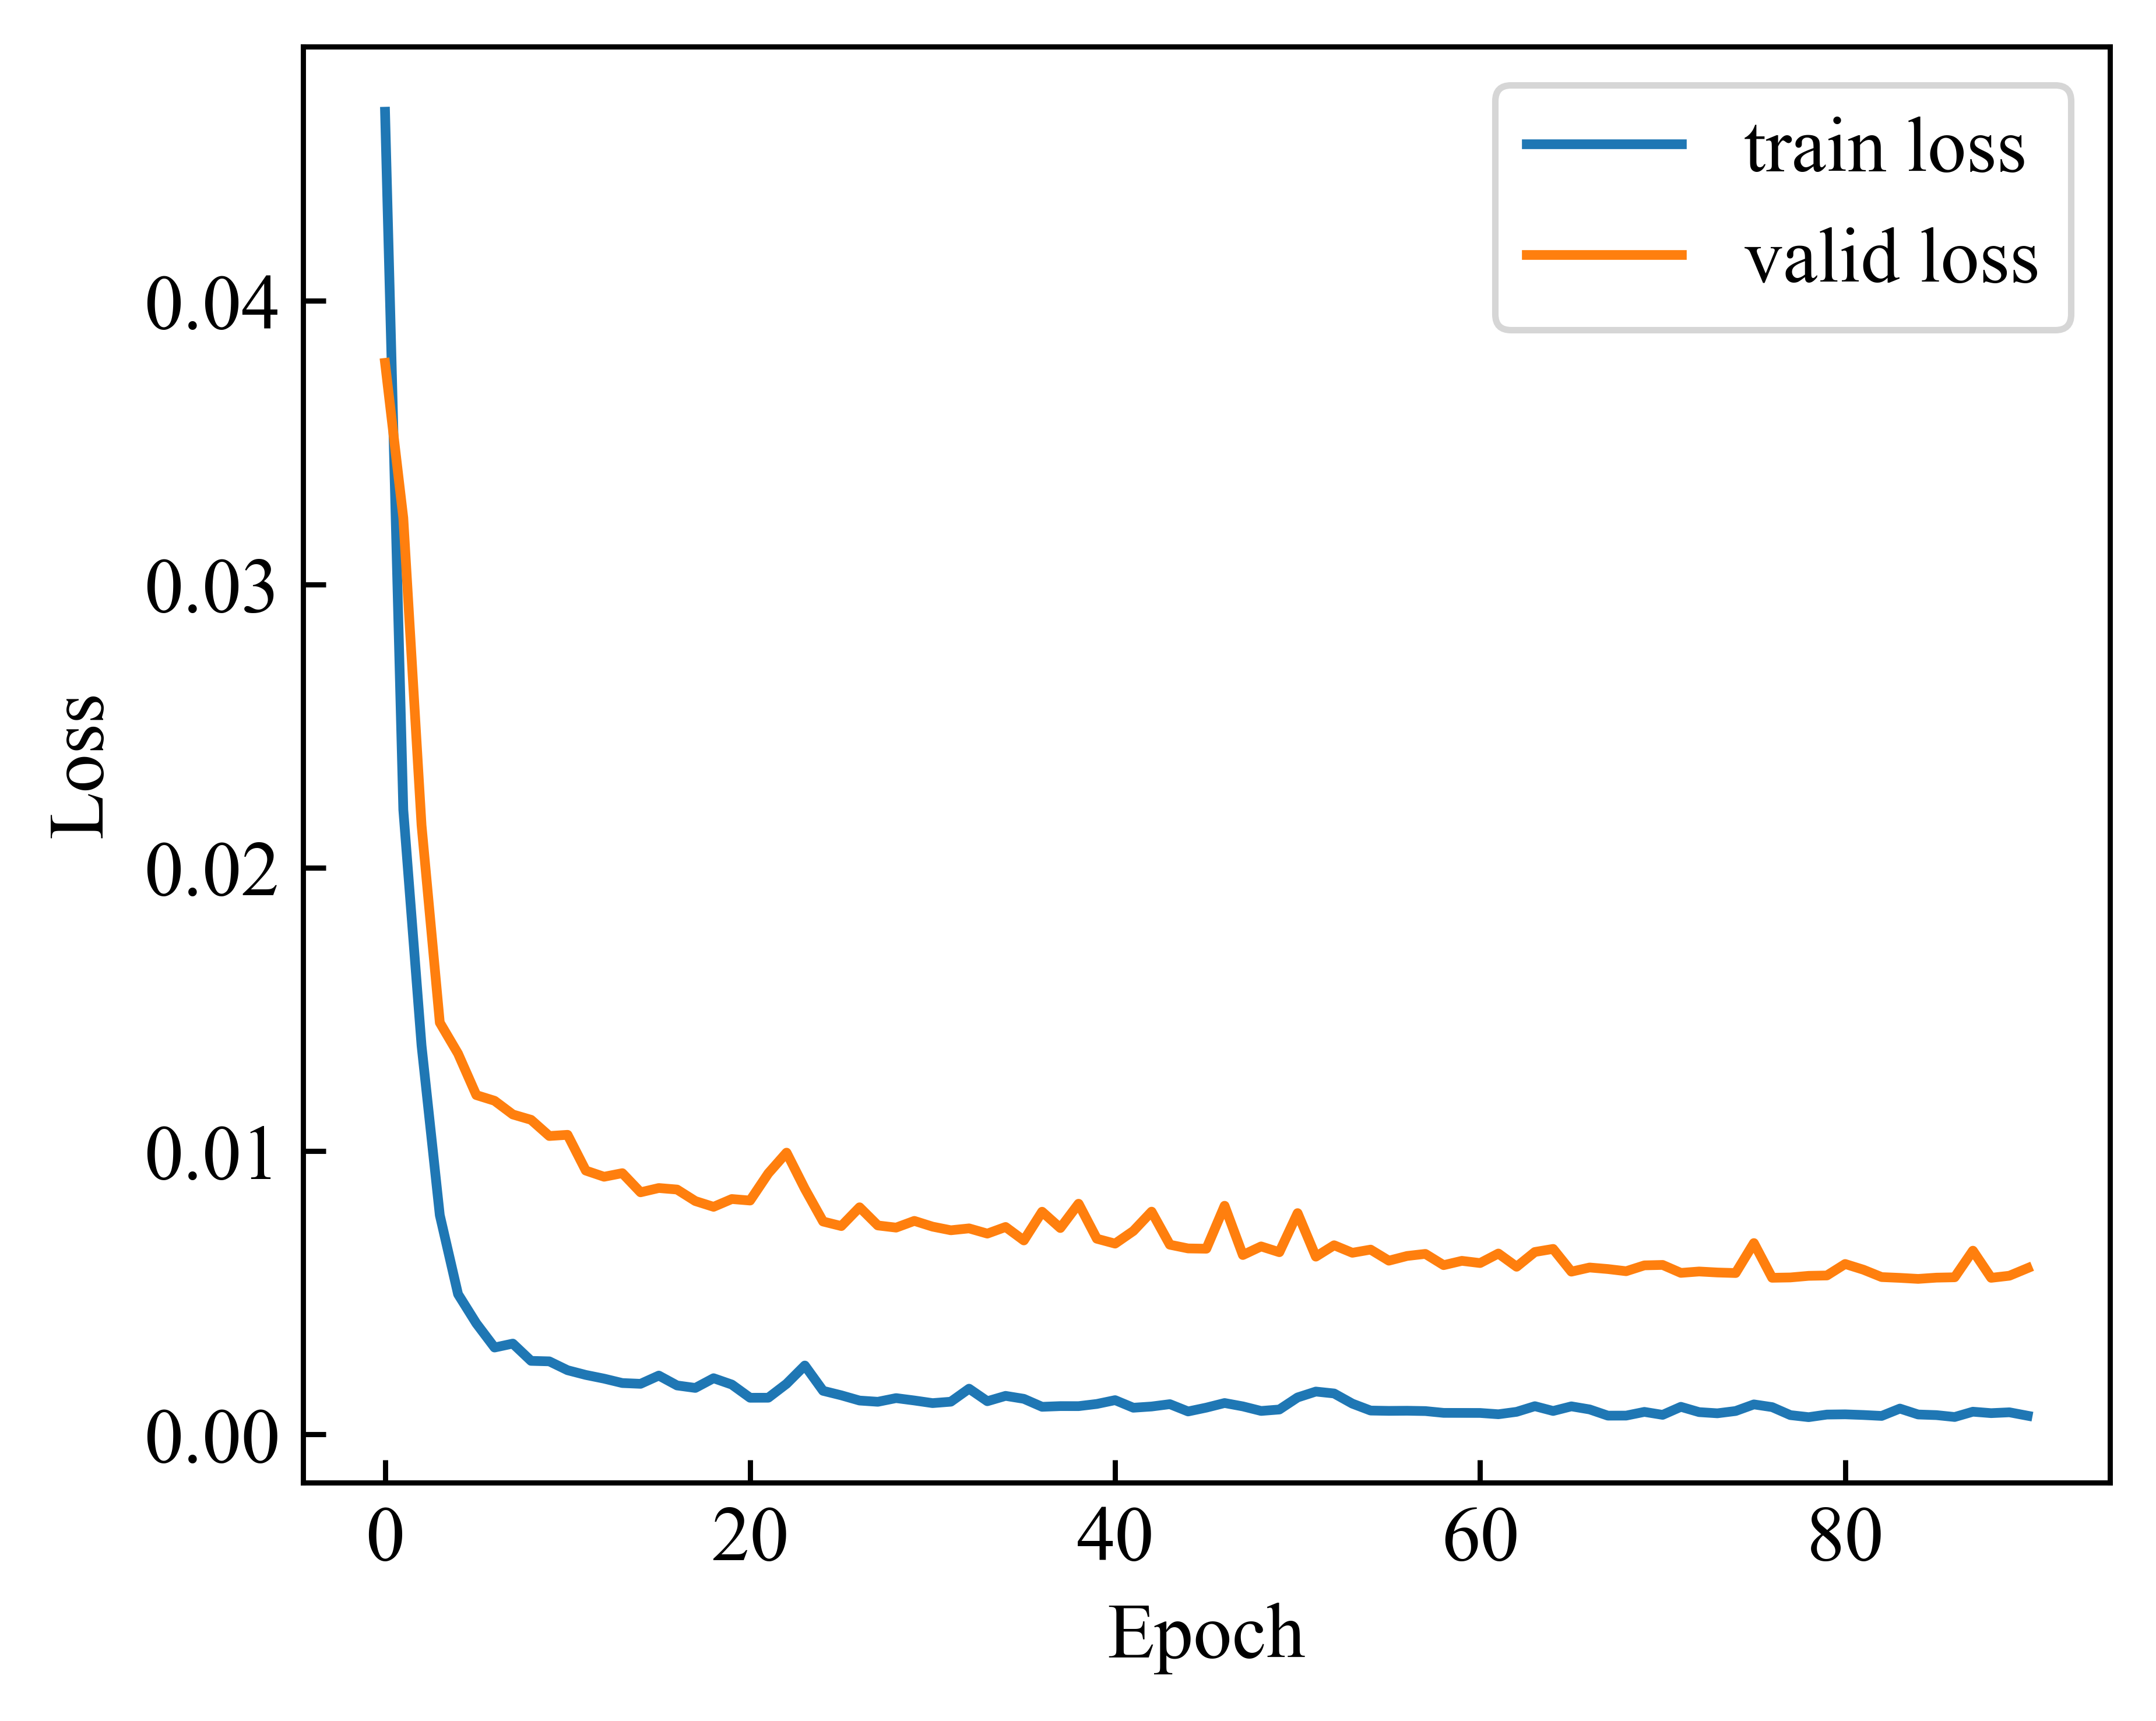

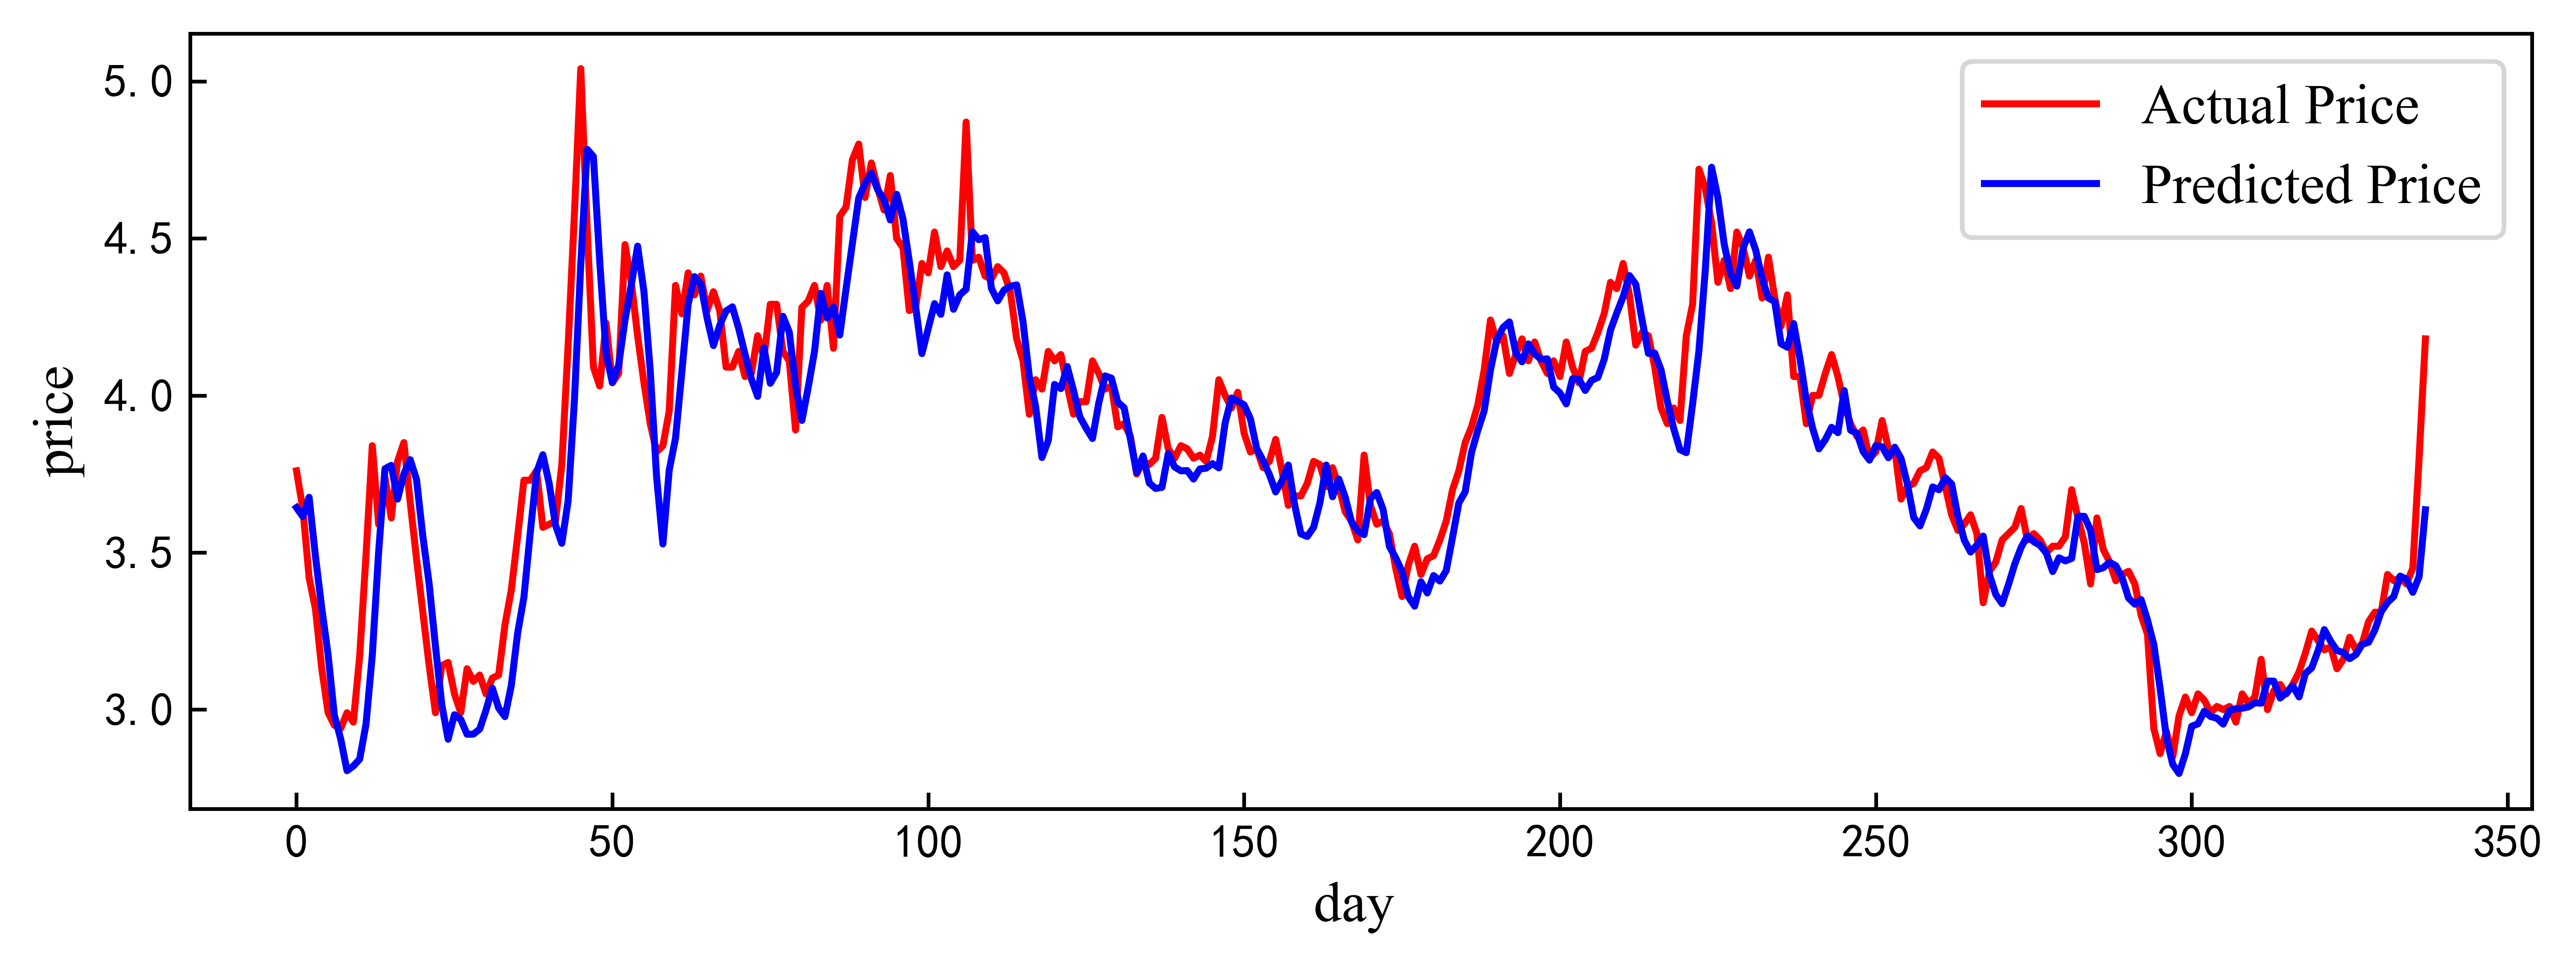

SSA-LSTM的mape: 0.031119348330319027  rmse: 0.1678201233048593  mae: 0.12017380310938908  R2: 0.8702830226236045
Running time: %s Seconds 16.932769965000006


In [2]:
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)
# In[] 加载数据
xlsfile = pd.read_excel('数据集/002168li.xls').iloc[0:, 1:]  # 第一列与第二列的日期不作为特征之一
data=np.array(xlsfile)

from model import split_data
time_steps=30
in_,out_=split_data(data,time_steps)
n=range(in_.shape[0])
m=-338#最后两天测试
train_data = in_[n[0:m],]
test_data = in_[n[m:],]
train_label = out_[n[0:m],]
test_label = out_[n[m:],]
# 归一化
ss_X=MinMaxScaler(feature_range=(0,1)).fit(train_data)
ss_y=MinMaxScaler(feature_range=(0,1)).fit(train_label)
train_data = ss_X.transform(train_data)
train_label = ss_y.transform(train_label)
ss_X=MinMaxScaler(feature_range=(0,1)).fit(test_data)
ss_y=MinMaxScaler(feature_range=(0,1)).fit(test_label)
test_data = ss_X.transform(test_data)
test_label = ss_y.transform(test_label)

# In[]定义超参数
# 加载4中优化好的参数
pop=loadmat('结果/002168lissa_para.mat')['best'].reshape(-1,)
alpha = pop[0]  # 学习率
num_epochs = int(pop[1])#迭代次数
hidden_nodes0 = int(pop[2])#第一隐含层神经元
hidden_nodes = int(pop[3])#第二隐含层神经元
batch_size = 32 # batchsize
input_features = train_data.shape[1]
output_class = train_label.shape[1]

# placeholder
X = tf.placeholder("float", [None, input_features])
Y = tf.placeholder("float", [None, output_class])


# 定义一个隐层的神经网络
def RNN(x):
    x = tf.reshape(x, [-1, 1, input_features])
    # 定义输出层权重
    weights = {'out': tf.Variable(tf.random_normal([hidden_nodes, output_class]))}
    biases = {'out': tf.Variable(tf.random_normal([output_class]))}
    lstm_cell0 = tf.nn.rnn_cell.LSTMCell(hidden_nodes0)
    lstm_cell = tf.nn.rnn_cell.LSTMCell(hidden_nodes)
    lstm_cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell0, lstm_cell])
    # 初始化
    init_state = lstm_cell.zero_state(tf.shape(x)[0], dtype=tf.float32)
    outputs, _ = tf.nn.dynamic_rnn(lstm_cell, x, dtype=tf.float32, initial_state=init_state)

    output_sequence = tf.matmul(tf.reshape(outputs, [-1, hidden_nodes]), weights['out']) + biases['out']
    return tf.reshape(output_sequence, [-1, output_class])


# In[] 初始化
logits = RNN(X)
loss = tf.losses.mean_squared_error(predictions=logits, labels=Y)
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    alpha,
    global_step,
    num_epochs, 0.99,
    staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=1e-10).minimize(loss, global_step=global_step)
init = tf.global_variables_initializer()

# In[]训练
train = []
valid = []
with tf.Session() as sess:
    sess.run(init)
    N = train_data.shape[0]
    for epoch in range(num_epochs):
        total_batch = int(math.ceil(N / batch_size))
        indices = np.arange(N)
        np.random.shuffle(indices)
        avg_loss = 0
        # 迭代训练，顺便计算训练集loss
        for i in range(total_batch):
            rand_index = indices[batch_size * i:batch_size * (i + 1)]
            x = train_data[rand_index]
            y = train_label[rand_index]
            _, cost = sess.run([optimizer, loss],
                               feed_dict={X: x, Y: y})
            avg_loss += cost / total_batch

        # 计算测试集loss
        valid_data = test_data
        valid_y = test_label
        valid_loss = sess.run(loss, feed_dict={X: valid_data, Y: valid_y})

        train.append(avg_loss)
        valid.append(valid_loss)
        print('epoch:', epoch, ' ,train loss ', avg_loss, ' ,valid loss: ', valid_loss)

    # 计算训练集与测试集的预测值
    train_pred = sess.run(logits, feed_dict={X: train_data})
    test_pred = sess.run(logits, feed_dict={X: test_data})
# 对测试结果进行反归一化
test_pred = ss_y.inverse_transform(np.array(test_pred.reshape(-1,1)))
test_label = ss_y.inverse_transform(test_label)

# print("zxx123",test_pred)
# In[] 画loss曲线
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 12,
}
from pylab import mpl
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.sans-serif'] = ['SimHei'] #指定默认字体
mpl.rcParams['axes.unicode_minus'] = False
g = plt.figure(figsize=(5, 4), dpi=800)
plt.ylabel('Loss',fontproperties = 'Times New Roman', fontsize=12)
plt.xlabel('Epoch',fontproperties = 'Times New Roman', fontsize=12)
plt.xticks(fontproperties = 'Times New Roman', fontsize=12)
plt.yticks(fontproperties = 'Times New Roman', fontsize=12)
plt.plot(train, label='train loss')
plt.plot(valid, label='valid loss')
plt.legend(prop = font1)
# plt.show()
# In[]
# 画出测试集的值
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
test_label = test_label.reshape(-1, 1)
test_pred = test_pred.reshape(-1, 1)
plt.figure(figsize=(9, 3), dpi=800)
plt.plot(test_label, c='r', label='Actual Price')
plt.plot(test_pred, c='b',label='Predicted Price')
plt.xlabel('day ',fontproperties = 'Times New Roman', fontsize=12)
plt.ylabel('price',fontproperties = 'Times New Roman', fontsize=12)
plt.legend(prop = font1)
plt.savefig('figure/002168-SSA-LSTM预测结果.jpg')
plt.show()
savemat('结果/002168ssa_lstm_result.mat', {'true': test_label, 'pred': test_pred})
# In[]计算各种指标
# mape
test_mape = np.mean(np.abs((test_pred - test_label) / test_label))
# rmse
test_rmse = np.sqrt(np.mean(np.square(test_pred - test_label)))
# mae
test_mae = np.mean(np.abs(test_pred - test_label))
# R2
test_r2 = r2_score(test_label, test_pred)


print('SSA-LSTM的mape:', test_mape, ' rmse:', test_rmse, ' mae:', test_mae, ' R2:', test_r2)


tis2 =time.perf_counter()
print('Running time: %s Seconds',tis2-tis1)